<a href="https://colab.research.google.com/github/nicolastrimborn/RPW_PMJ_Group/blob/master/JupyterNotebook/HotEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HotEnd

## RTD


### Hardware
![alt text](https://drive.google.com/uc?id=1mgSImOT2LJb-yuMfArm2hazKT6hKeQA0)

[RTD Module](https://www.beckhoff.com/EL3202/)\
[Datasheet](https://download.beckhoff.com/download/document/io/ethercat-terminals/el32xxen.pdf)

If the EL3201/EL3202 is operated with a two-wire connection, the inputs +R and +RL must be bridged by the user.

P100 Measurement at Room Temp With Leads = 109 Ohm
Module "Value" Reading at RT = 221

### Scaling

ADC value of EL3202 is stored as INT type.
* LB = -32768
* UB= 32767
* Memory = 16 Bit

In [0]:
Raw value = 221

<a href="https://colab.research.google.com/github/nicolastrimborn/RPW_PMJ_Group/blob/master/JupyterNotebook/Maxon_Motor_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Control

## Drive State
![alt text](https://drive.google.com/uc?id=14Kwsdnyo5GGpvTvo5LNxnTdDEfRBDR3I)

## Control Word
![alt text](https://drive.google.com/uc?id=1_4RG8IrNsgCcCCZuwJhPFGzfX31RgPZW)

## Status Word
![alt text](https://drive.google.com/uc?id=1MAXy9yOu0d468Aeazjn73ph9VA1ugjU_)

## Encoder Scaling
Motor: [link text](http://www.servovision.com/Motor1/E/157.pdf)\
Encoder: [link text](https://www.maxongroup.com/medias/sys_master/root/8831078924318/2018EN-419.pdf)\
Gearbox [link text](https://www.maxongroup.com/medias/sys_master/root/8831028494366/2018EN-333.pdf)\
Motor and GB Combo:  [link text](https://www.maxongroup.com/maxon/view/service_search?query=359565)

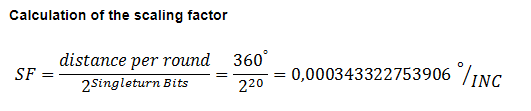

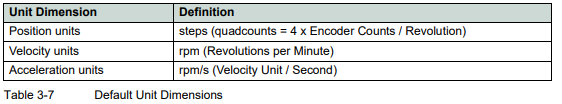

In [0]:
encoderCounts = 512
RevolutionDeg = 360
GBratio = 128
SF = (RevolutionDeg/(encoderCounts*4))/GBratio
print('Scaling factor: ', SF)

Scaling factor:  0.001373291015625


<a href="https://colab.research.google.com/github/nicolastrimborn/RPW_PMJ_Group/blob/master/JupyterNotebook/StepperMotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stepper Motor


## Specs

![alt text](https://drive.google.com/uc?id=1m0vmRihSnLJvtidjZyr2zxn77GmrcX9z)

---



## Wiring Diagram

![alt text](https://drive.google.com/uc?id=1e1hG3SjZGp06CqxoFPHiZ0RN5QLszW3f)

## Calculations

In [0]:
# Motor Parameters
PI = 3.1415
StepAngle = 0.9
MotorSteps = 360/StepAngle
# Driver Parameters
Microstepping = 64
StepsPerRevolution = MotorSteps * Microstepping
# Extruder Properties
GearRatio = 3
HobbDia = 7.3

# Extruder Steps per 1mm of Filament
eStepsPerMM = (MotorSteps * Microstepping * GearRatio)/(HobbDia * PI)
MMPerStep = 1/eStepsPerMM
DistancePerRevolution = StepsPerRevolution * MMPerStep
print("StepsPerRevolution = ", StepsPerRevolution)
print("eStepsPerMM = " ,eStepsPerMM)
print("MMPerStep = " ,MMPerStep)
print("DistancePerRevolution = " ,DistancePerRevolution)

StepsPerRevolution =  25600.0
eStepsPerMM =  3348.893186441343
MMPerStep =  0.0002986061197916667
DistancePerRevolution =  7.6443166666666675


### Beckoff tool
![alt text](https://drive.google.com/uc?id=1BjXWi_dFCCp3zlSrKMNpVrAWMXN_VJxx)

### Fine Tuning
https://e3d-online.dozuki.com/Guide/Titan+Marlin+Configuration/35

In [0]:
desiredExtDist = 100
actualExtDist = 104
overExtrudPercent = actualExtDist/desiredExtDist
MMPerStepTuned = MMPerStep *overExtrudPercent
print("MMPerStepTuned=", MMPerStepTuned)

MMPerStepTuned= 0.00031055036458333334
